# Utils

In [2]:
# Libraries
import pandas as pd
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
import warnings
import sys
import numpy as np

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("/Users/emmatosato/Documents/PhD/ANM_Verona/src/processing")

# Scripts
import importlib
from preprocessing import processflat
from analysis import umap_run, clustering_evaluation, clustering, regression

importlib.reload(clustering_evaluation)
importlib.reload(regression)
importlib.reload(clustering)
importlib.reload(umap_run)
importlib.reload(processflat)

from analysis.clustering import plot_clusters_vs_groups
from preprocessing.processflat import x_features_return

%load_ext autoreload
%autoreload 2

In [3]:
# FC maps directories
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/data/FCmaps_augmented_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"

# Path to masks
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'

# Metadata
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/DocumeAnts/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'
path_df_meta = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/meta/df_meta.csv"

# Done dataframe of preprocessed FC maps
path_df_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_gm.pkl"
path_df_thr02_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_thr02_gm.pkl"

# Data

## Raw data

#### One file example

In [4]:
# Load an image
path_temp = os.path.join(dir_FCmaps, '1_S_5005.FDC.nii.gz')
img = nib.load(path_temp)

# Separate the data and affine
temp_img = img.get_fdata()      # 3D volume data
temp_affine = img.affine        # 4x4 affine matrix

# Print shapes
print(temp_img.shape)
print(temp_affine.shape)

(91, 109, 91)
(4, 4)


#### Load data

Function for listing the data in nii.gz format and extract the subjects identifiers + printing some infos

In [5]:
def listData_saveID(dir):
    # All nii.gz files in the directory
    files_path = sorted(glob.glob(os.path.join(dir, '*gz')))

    # Extract Subject IDs from filenames
    subject_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files_path]

    # Sanity checks
    assert len(files_path) == len(subject_id), (
        f"Mismatch count: {len(files_path)} files vs {len(subject_id)} IDs"
    )
    assert len(subject_id) == len(set(subject_id)), "ID duplicated"
    for fp, sid in zip(files_path, subject_id):
        fname = os.path.basename(fp)
        expected = sid + '.FDC.nii.gz'
        assert fname == expected, (
            f"Filename “{fname}” do not correspond to the extracted ID“{sid}”"
        )

    print("Check length:")
    print("Files: ", len(files_path))
    print("Subject: ", len(subject_id))

    return files_path, subject_id

In [6]:
files, sub_id = listData_saveID(dir_FCmaps)

Check length:
Files:  176
Subject:  176


In [7]:
maps_FDC = []
for path in files:
    print(path)
    data = nib.load(path).get_fdata().flatten()
    maps_FDC.append(data)

# Stores subjects as rows and voxels as columns
df=pd.DataFrame(maps_FDC)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/012_S_4188.FDC.nii.gz

In [8]:
# Copy without id
df_eda = df.copy()

In [9]:
# Insert subjects id
df.insert(0, 'ID', sub_id)
print("\n", df.shape, "\n")


 (176, 902630) 



Some asserts

In [10]:
# 1Ensure the EDA copy has one row per file
assert df_eda.shape[0] == len(files), (
    f"Rows in df_eda ({df_eda.shape[0]}) != number of files ({len(files)})"
)

# Ensure the df has one row per subject ID
assert df.shape[0] == len(sub_id), (
    f"Number of rows ({df.shape[0]}) != number of IDs ({len(sub_id)})"
)

# Verify the ID column matches the original sub_id order exactly
assert df['ID'].tolist() == sub_id, "Row IDs do not match the original sub_id order"

# Confirm there are no duplicate IDs
assert df['ID'].is_unique, "There are duplicate IDs in the DataFrame"

# Check that inserting the ID column did not alter the numeric data
numeric_equal = (df.drop('ID', axis=1).values == df_eda.values).all()
assert numeric_equal, "Numeric data was altered when inserting the ID column"

#### EDA

In [11]:
print(f"Shape of the dataframes: {df_eda.shape}")

Shape of the dataframes: (176, 902629)


In [12]:
# Global Statistics
all_voxels = df_eda.values.flatten()
all_voxels = all_voxels[~np.isnan(all_voxels)]

# Descriptive statistics
stats_summary = {
    "Min": np.min(all_voxels),
    "Max": np.max(all_voxels),
    "Mean": np.mean(all_voxels),
    "Std": np.std(all_voxels),
    "1st Percentile": np.percentile(all_voxels, 1),
    "25th Percentile": np.percentile(all_voxels, 25),
    "Median (50th)": np.percentile(all_voxels, 50),
    "75th Percentile": np.percentile(all_voxels, 75),
    "99th Percentile": np.percentile(all_voxels, 99),
}

df_stats = pd.DataFrame.from_dict(stats_summary, orient='index', columns=['Value'])
print(df_stats)

                    Value
Min             -0.549580
Max              1.618776
Mean             0.021996
Std              0.056745
1st Percentile  -0.013393
25th Percentile  0.000000
Median (50th)    0.000000
75th Percentile  0.008759
99th Percentile  0.269354


## Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [13]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(cognitive_dataset, sheet_name='Sheet1')
df_meta['Age'] = df_meta['Age'].round(1)

In [14]:
df_meta.head(5)

,ID,Group,Sex,Age,Education,CDR_SB,MMSE
0,002_S_4654,ADNI,F,80.4,18,1.5,27.0
1,002_S_6695,ADNI,M,66.3,18,4.5,25.0
2,003_S_6264,ADNI,M,58.3,12,2.5,23.0
3,003_S_6268,ADNI,M,71.6,20,0.5,29.0
4,003_S_6432,ADNI,F,67.3,18,0.5,30.0


### EDA on Labels

#### General info

In [15]:
print("Meta dataset BEFORE removing a subject")
print(df_meta.shape)

# Remove the subject with ID "4_S_5003"
df_meta = df_meta[df_meta['ID'] != '4_S_5003'].reset_index(drop=True)

print("Meta dataset AFTER removing a subject")
print(df_meta.shape)

Meta dataset BEFORE removing a subject
(177, 7)
Meta dataset AFTER removing a subject
(176, 7)


In [16]:
# Saving the new csv
df_meta.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/labels.csv", index=False)

In [17]:
print(df_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         176 non-null    object 
 1   Group      176 non-null    object 
 2   Sex        176 non-null    object 
 3   Age        176 non-null    float64
 4   Education  176 non-null    int64  
 5   CDR_SB     171 non-null    float64
 6   MMSE       168 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 9.8+ KB
None


#### Missing values

In [18]:
print("\nMissing values for column:")
print(df_meta.isna().sum())


Missing values for column:
ID           0
Group        0
Sex          0
Age          0
Education    0
CDR_SB       5
MMSE         8
dtype: int64


#### Unique values

WITH NaN


In [19]:
print("\nUnique Values:")
print("Group:", sorted(df_meta['Group'].unique()))
print("CDR_SB:", np.sort(df_meta['CDR_SB'].unique()))
print("MMSE:", np.sort(df_meta['MMSE'].unique()))


Unique Values:
Group: ['ADNI', 'CBS', 'PSP']
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18.   nan]
MMSE: [ 4.  5.  8.  9. 10. 11. 12. 14. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30. nan]


Unique values WITHOUT NaN

In [20]:
cdr_sb_no_nan = df_meta['CDR_SB'].dropna()
mmse_no_nan = df_meta['MMSE'].dropna()

In [21]:
print("\nUnique Values:")
print("CDR_SB:", np.sort(cdr_sb_no_nan.unique()))
print("MMSE:", np.sort(mmse_no_nan.unique()))


Unique Values:
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18. ]
MMSE: [ 4.  5.  8.  9. 10. 11. 12. 14. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30.]


In [22]:
print(df_meta.select_dtypes(include='number').describe().round(1))

         Age  Education  CDR_SB   MMSE
count  176.0      176.0   171.0  168.0
mean    70.9       15.8     4.1   24.1
std      8.4        3.5     3.4    5.0
min     53.0        2.0     0.0    4.0
25%     64.0       14.0     1.5   22.0
50%     71.2       16.0     3.5   25.0
75%     76.0       18.0     6.0   28.0
max     93.8       27.0    18.0   30.0


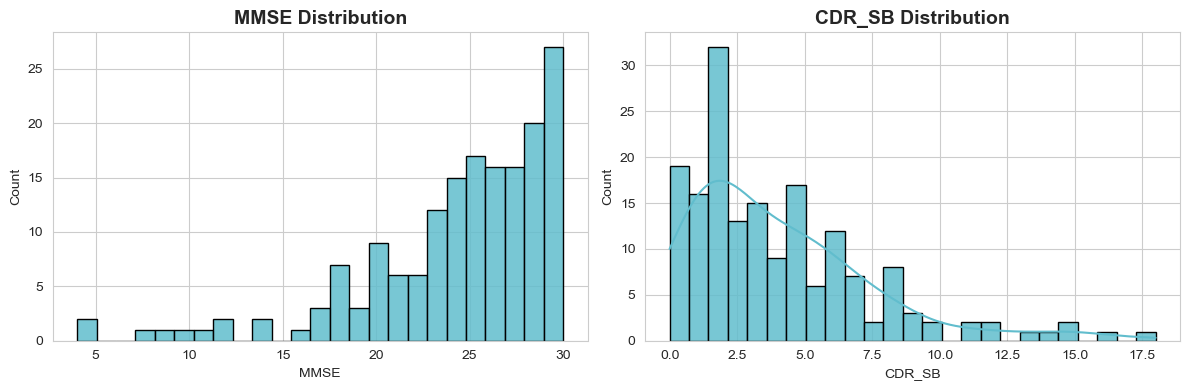

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(mmse_no_nan, bins=25, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.85)
axes[0].set_title("MMSE Distribution", fontsize=14, weight='bold')

sns.histplot(cdr_sb_no_nan, bins=25, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.85, kde=True)
axes[1].set_title("CDR_SB Distribution", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

#### CDR

In [24]:
df_meta_sorted = df_meta[['ID', 'CDR_SB']].sort_values(by='CDR_SB', ascending=False)
print(df_meta_sorted)

             ID  CDR_SB
53     1_S_5007    18.0
65     1_S_5023    16.0
12   012_S_4188    15.0
48     1_S_5001    15.0
32   036_S_4430    14.0
..          ...     ...
92     1_S_5052     NaN
125    1_S_5096     NaN
126    1_S_5097     NaN
128    1_S_5101     NaN
164    4_S_5008     NaN

[176 rows x 2 columns]


### GMM on CDR_SB

- Assigning each CDB_SB value to a cluster using GMM, removing NaN values before
- New column for the metadata dataframe

In [26]:
# Filter valid CDR_SB values
df_cdr = df_meta[['ID', 'CDR_SB']].dropna().copy()
print("Dimensions after dropping NaN", df_cdr.shape)

# Fit GMM and predict raw labels
np.random.seed(42)
x_gmm = df_cdr['CDR_SB'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=3, random_state=42).fit(x_gmm)
df_cdr['GMM_Label'] = gmm.predict(x_gmm)

# Reorder labels by CDR_SB severity
means = df_cdr.groupby('GMM_Label')['CDR_SB'].mean().sort_values()
label_map = {old: new for new, old in enumerate(means.index)}
df_cdr['GMM_Label'] = df_cdr['GMM_Label'].map(label_map)

# Include in metadata
label_map = dict(zip(df_cdr['ID'], df_cdr['GMM_Label']))
df_meta = df_meta.drop(columns=['GMM_Label'], errors='ignore')
df_meta['GMM_Label'] = df_meta['ID'].map(label_map).astype('Int64')

Dimensions after dropping NaN (171, 2)


In [27]:
print(df_meta['GMM_Label'].value_counts().sort_index())

GMM_Label
0    80
1    76
2    15
Name: count, dtype: Int64


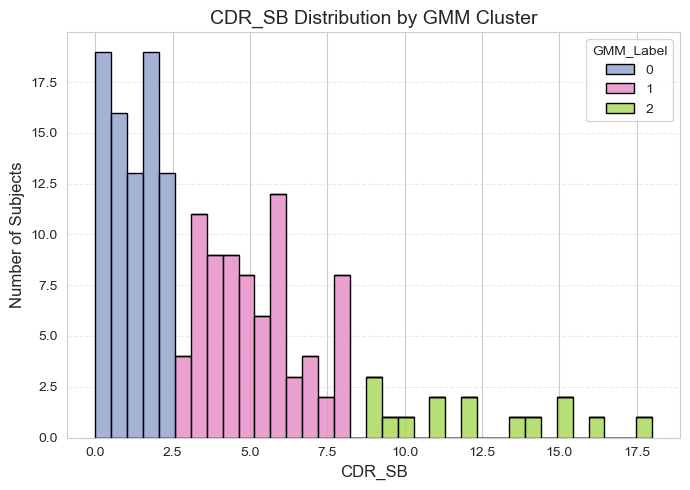

In [28]:
plt.figure(figsize=(7, 5))

set_2 = sns.color_palette("Set2")[2:]

sns.histplot(
    data=df_meta.dropna(subset=['CDR_SB', 'GMM_Label']),
    x='CDR_SB',
    hue='GMM_Label',
    palette=set_2,
    multiple='stack',   # oppure 'dodge' per barre affiancate
    bins=35,
    edgecolor='black',
    alpha=0.8
)

plt.xlabel("CDR_SB", fontsize=12)
plt.ylabel("Number of Subjects", fontsize=12)
plt.title("CDR_SB Distribution by GMM Cluster", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

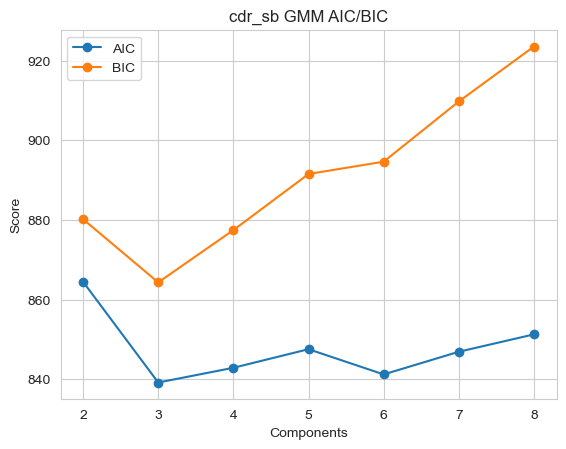

In [29]:
aic, bic = evaluate_gmm(x_gmm, K_range=range(2, 9), save_path= None, prefix="cdr_sb", plot_flag=True)

## Yeo Data

In [30]:
df_networks_no_thr = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_noTHR.csv")
df_networks_thr01 = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_thr01.csv")
df_networks_thr02 = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_thr02.csv")

In [31]:
df_networks_no_thr = df_networks_no_thr.rename(columns={"CODE": "ID"})
df_networks_thr01 = df_networks_thr01.rename(columns={"CODE": "ID"})
df_networks_thr02 = df_networks_thr02.rename(columns={"CODE": "ID"})

In [32]:
features_network = ['VIS_mean', 'VAN_mean', 'DAN_mean', 'DMN_mean', 'LMB_mean', 'FPN_mean', 'SMN_mean', 'SUBCORTICAL_mean']

# Preprocessing

## Load data

Recall the dataframe with ID and values of the maps

In [33]:
print("\n", df.shape, "\n")
df.iloc[:5, :5]


 (176, 902630) 



,ID,0,1,2,3
0,002_S_4654,0.0,0.0,0.0,0.0
1,002_S_6695,0.0,0.0,0.0,0.0
2,003_S_6264,0.0,0.0,0.0,0.0
3,003_S_6268,0.0,0.0,0.0,0.0
4,003_S_6432,0.0,0.0,0.0,0.0


Merging the meta columns with the above dataframe: the order of the subject must be the same of the dataframe of the FC maps

In [34]:
df_meta = df_meta.set_index('ID').loc[df['ID']].reset_index()

assert all(df['ID'] == df_meta['ID']), "Mismatch between ID of df and df_meta_ordered"
print("The ID are now perfectly aligned")

The ID are now perfectly aligned


In [35]:
df.shape

(176, 902630)

## Thresholding

Set a threshold for values below 0.1 and 0.2 for defining correlation

In [36]:
def apply_threshold(dataframe, threshold):
    df_thr = dataframe.copy()
    df_thr.iloc[:, 1:] = df_thr.iloc[:, 1:].mask(df_thr.iloc[:, 1:] < threshold, 0)
    return df_thr

In [37]:
df_thr_01 = apply_threshold(df, threshold=0.1)

In [38]:
df_thr_02 = apply_threshold(df, threshold=0.2)

## Masking


- Binary mask of grey matter using the Harvard-Oxford Atlas

- Keeping the Gray Matter voxels

In [39]:
def apply_mask(df_thr, mask_path):
    # Load and flatten GM mask
    mask = nib.load(mask_path).get_fdata().flatten()
    assert mask.shape[0] == df_thr.shape[1] - 1, "Mask and data length mismatch"

    # Mask
    voxel_data = df_thr.iloc[:, 1:]
    voxel_data_masked = voxel_data.loc[:, mask != 0]

    # Return the masked dataframes
    df_masked = pd.concat([df_thr[['ID']], voxel_data_masked], axis=1)
    df_masked.columns = ['ID'] + list(range(voxel_data_masked.shape[1]))
    return df_masked

In [40]:
# GM masking
# 0.1 threshold
df_thr01_gm = apply_mask(df_thr_01, gm_mask_path)

# 0.2 threshold
df_thr02_gm = apply_mask(df_thr_02, gm_mask_path)

# Without threshold
df_gm = apply_mask(df, gm_mask_path)

In [41]:
# Harvard masking
# 0.1 threshold
df_thr01_har = apply_mask(df_thr_01, harvard_oxford_mask_path)

# 0.2 threshold
df_thr02_har = apply_mask(df_thr_02, harvard_oxford_mask_path)

# Without
df_har = apply_mask(df, harvard_oxford_mask_path)

## EDA

In [42]:
print("Dimensions of dataframes after gm masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_gm.shape)
print("0.2 threshold", df_thr02_gm.shape)

print("\nDimensions of dataframes after harvard masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_har.shape)
print("0.2 threshold", df_thr02_har.shape)

print("\nDimensions of dataframes after gm masking and harvard masking without thresholding:")
print("GM Mask", df_gm.shape)
print("Harvard Mask", df_har.shape)

Dimensions of dataframes after gm masking with 2 different thresholds:
0.1 threshold (176, 161818)
0.2 threshold (176, 161818)

Dimensions of dataframes after harvard masking with 2 different thresholds:
0.1 threshold (176, 55005)
0.2 threshold (176, 55005)

Dimensions of dataframes after gm masking and harvard masking without thresholding:
GM Mask (176, 161818)
Harvard Mask (176, 55005)


In [43]:
def summarize_voxel_data(df_masked, threshold=None):
    summary = {}
    summary['Shape'] = df_masked.shape

    if threshold:
        has_low = ((df_masked.iloc[:, 1:] > 0) & (df_masked.iloc[:, 1:] < threshold)).any().any()
        summary['Valori tra 0 e threshold'] = has_low
    else:
        summary['Valori tra 0 e threshold'] = 'N/A'

    zero_rows = (df_masked.iloc[:, 1:] == 0).all(axis=1).sum()
    summary['Zero maps'] = f"{zero_rows} su {df_masked.shape[0]}"

    voxel_data = df_masked.iloc[:, 1:].values
    nonzero_voxels = voxel_data[voxel_data != 0]

    summary['All Min'] = voxel_data.min()
    summary['All Max'] = voxel_data.max()
    summary['All Mean'] = voxel_data.mean()
    summary['All Std'] = voxel_data.std()

    summary['Nonzero Min'] = nonzero_voxels.min()
    summary['Nonzero Max'] = nonzero_voxels.max()
    summary['Nonzero Mean'] = nonzero_voxels.mean()
    summary['Nonzero Std'] = nonzero_voxels.std()

    return summary

In [44]:
# Dataset
dataframes = {
    "thr_01_gm": (df_thr01_gm, 0.1),
    "thr_02_gm": (df_thr02_gm, 0.2),
    "thr_01_har": (df_thr01_har, 0.1),
    "thr_02_har": (df_thr02_har, 0.2),
    "gm_no_thr": (df_gm, None),
    "har_no_thr": (df_har, None)
}

# Functions
results = []

for name, (dfm, thr) in dataframes.items():
    summary = summarize_voxel_data(dfm, threshold=thr)
    summary['Dataset'] = name
    results.append(summary)

# Summary
df_summary = pd.DataFrame(results).set_index('Dataset')
pd.options.display.float_format = '{:.4f}'.format

In [45]:
print("Summary of voxel data:")
display(df_summary)

Summary of voxel data:


,Shape,Valori tra 0 e threshold,Zero maps,All Min,All Max,All Mean,All Std,Nonzero Min,Nonzero Max,Nonzero Mean,Nonzero Std
Dataset,,,,,,,,,,,
thr_01_gm,"(176, 161818)",False,0 su 176,0.0000,1.6188,0.0736,0.1022,0.1000,1.6188,0.1829,0.0771
thr_02_gm,"(176, 161818)",False,0 su 176,0.0000,1.6188,0.0343,0.0943,0.2000,1.6188,0.2750,0.0715
thr_01_har,"(176, 55005)",False,0 su 176,0.0000,1.6188,0.0846,0.1068,0.1000,1.6188,0.1867,0.0783
thr_02_har,"(176, 55005)",False,8 su 176,0.0000,1.6188,0.0412,0.1022,0.2000,1.6188,0.2754,0.0723
gm_no_thr,"(176, 161818)",N/A,0 su 176,-0.2879,1.6188,0.1000,0.0871,-0.2879,1.6188,0.1000,0.0871
har_no_thr,"(176, 55005)",N/A,0 su 176,-0.1555,1.6188,0.1086,0.0916,-0.1555,1.6188,0.1086,0.0916
